## Descarga de datos provenientes de la plataforma Sentinel 2 Mediante Python usando SentinelSat

A lo largo de este notebook nos adentraremos al proceso de consulta y descarga de datos de la plataforma Sentinel2. Para ello usaremos la libreria [SentinelSat](https://sentinelsat.readthedocs.io/en/latest/api_reference.html), la cual permite la busqueda y descarga de datos de las plataformas Sentinel. Para iniciar como siempre vamos a importar las librerias que usaremos a lo largo del proceso

In [63]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import geopandas as gpd
import folium 
import rasterio as rio
from matplotlib import pyplot as plt
#from rasterio.crs import CRS
from rasterio import mask
import os
from pathlib import Path
import zipfile

Una vez importamos las librerias, el primer paso sera definir una zona de interes, la cual usaremos mas adelante con la finalidad de ser usada como AOI para el corte de la imagen sentinel que vamos a descargar. En este caso usaremos la capa de municipios disponible en el [portal de datos geograficos del DANE](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/descarga-mgn-marco-geoestadistico-nacional/), el cual fue usado en el marco del censo nacional de vivienda del 2018. Para la lectura del archivo usamos la libreria [Geopandas](https://geopandas.org/en/stable/docs/user_guide/io.html) la cual es una de las mas usadas cuando se trata de manipular datos geograficos tipo vector.

In [41]:
Municipios = gpd.read_file('Datos/MGN_MPIO_POLITICO.shp')

Vamos a plotear el mapa de municipios, para ello usamos la funcion **.show** de la librerias **matplotlib.pyplot**.

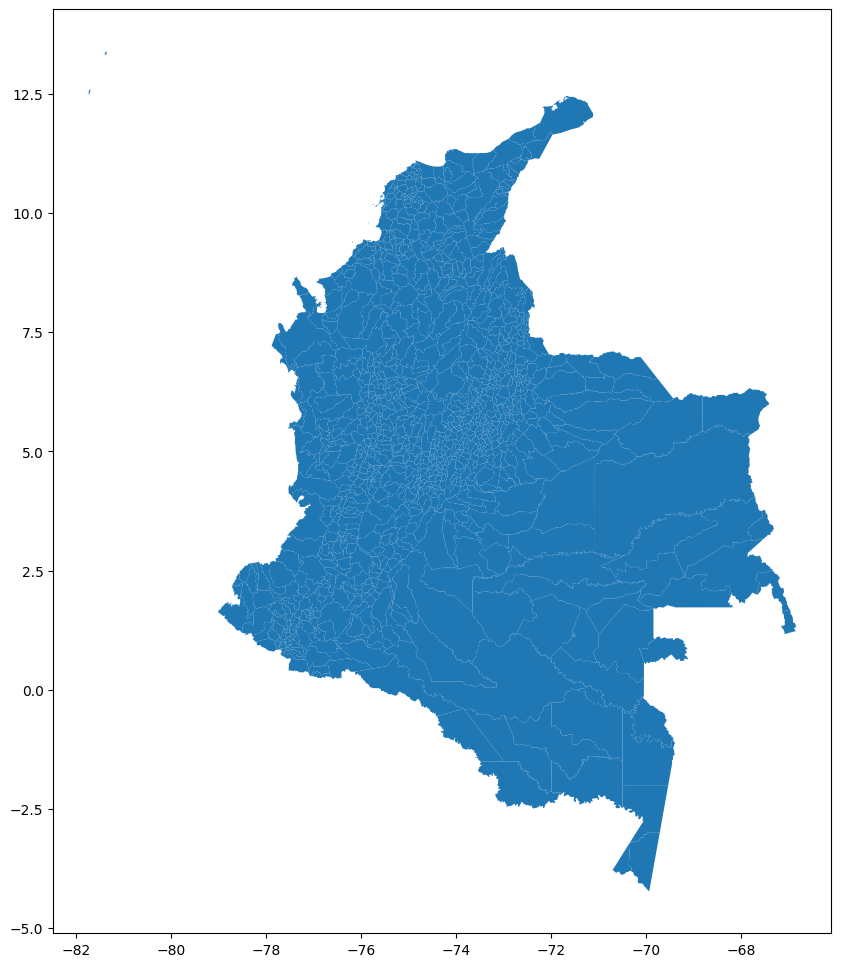

In [42]:
fig, ax = plt.subplots(figsize=(14, 12))
Municipios.plot(ax=ax)
plt.show()

El siguiente paso, radica en la definicion de la zona de interes. en este caso se define al municipio de Gachalá Cundinamarca como zona de interes. Para la definición del poligono hacemos un proceso de filtrado por condiciones sobre el dataframe de municipio cargado anteriormente; lo que se hace es instanciar una nueva variable llamada Gachala, la cual sera el resultado del proceso de filtrado.

In [ ]:
Gachala = Municipios[(Municipios.DPTO_CNMBR =='CUNDINAMARCA') & (Municipios.MPIO_CNMBR == 'GACHALÁ')]

Al igual que con el mapa de municipios, vamos a plotear la zona de interes, solo que en este caso usaremos  la libreria [folium](https://python-visualization.github.io/folium/) para mostrar la zona de interes usando un mapa interactivo muy sencillo.

In [44]:
m = folium.Map([4.693328, -73.580525], zoom_start=12)
folium.GeoJson(Gachala).add_to(m)
m

El siguiente paso es transformar la zona de interes a la proyeccion en la cual se realizara el proceso de corte, Generalmente las imagenes sentinel 2, se encuentran referidas al sistema coordenado EPSG:32618, tambien conocido como UTM Zona 18N. Por su lado la capa de municipios esta referida a el sistema MAGNA SIRGAS, EPSG:4686. En este caso es necesario reproyectar la zona de interes, la libreria **geopandas** dispone de un metod llamado **to_crs** que permite realizar la conversion de coordendas, pasando del sistema EPSG:4886 al EPSG:32618.

In [48]:
gachala_proj = Gachala.to_crs({'init': 'epsg:32618'})

c:\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Los datos de los sistemas de referencia asigandos a la zona de interes antes y despues de la transformación se muestran acontinuación.

In [50]:
Gachala.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
gachala_proj.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Definida la zona de de interes, el siguiente paso sera la consulta de datos usando la libreria **SentinelSat**. Es importante recordar que para que este proceso se puede llevar a cabo de sebe contar con un registro en la plataformA [Copernicus Hub](https://apihub.copernicus.eu/). El primer paso radica en inicializar el SentinelAPI para lo cual necesitamos el nombre de usuario, la contrasela y el link de la pagina.

In [55]:
api = SentinelAPI('user_name', 'password', 'https://apihub.copernicus.eu/apihub')

El siguiente paso radica en definir la zona de interes, en este caso se usa un archivo en formato Geojson llamado cuadro, el cual tiene cobertura parcial sobre los minicipios de Ubala, Gacheta, Gama entre otros, los cuales hacen parte de la cuenca hidrografica del Rio Guavio. En este caso para cargar el archivo mencionados se usa la funcion **read_geojson**. 

In [ ]:
zonaIntD = read_geojson('D:/Programación_Python/Python-ArcPy/Datos/cuadro.geojson')

Veamos el cubrimiento de la zona de interes.

In [52]:
m = folium.Map([4.693328, -73.580525], zoom_start=12)
folium.GeoJson(zonaIntD).add_to(m)
m

EL siguiente paso para lc onsulta radica en el query de las imagenes disponibles. Previamente convertimos la zona de interes en formato goejson a formato WKT usando la funcion **geojson_to_wkt**. debido a que este el el formato en el cual se realiza la consulta en el API de sentinel. Igualmente es necesario definir una serie de parametros que son de utilidad para una conuslta mas efectiva. El primero de estos son las fechas entre las cuales se deben buscar imagenes, en este caso se buscaron datos entre el 20 de diciembre de 2017 y el 17 de mayo de 2022, la plataforma de la cual se consultan los datos es **"Sentinel-2"**, el valor de nubosidad maxima es de de 10%, y el limite de imagenes a buscar es 20.

Posterior a la consulta, exportaremos estos datos a un dataframe para identificar la escena deseada para descargar previamente

In [56]:
aoi_geoj = geojson_to_wkt(zonaIntD)

try:
    products = api.query(aoi_geoj,
                     date=('20171220', '20220517'),
                     platformname= 'Sentinel-2',
                     cloudcoverpercentage = (0, 10),
                     limit = 20
                     )
except Exception as e:
    print("Error :", e.args)

products_df = api.to_dataframe(products)

Veamos el resultado de la consulta.

In [57]:
products_df.head()

,title,link,link_alternative,link_icon,summary,ondemand,datatakesensingstart,generationdate,beginposition,endposition,...,uuid,illuminationazimuthangle,illuminationzenithangle,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage
a0a89250-c077-4c66-8da2-03b78849c0c1,S2A_MSIL1C_20220108T152641_N0301_R025_T18NXL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2022-01-08T15:26:41.024Z, Instrument: MS...",false,2022-01-08 15:26:41.024,2022-01-08 17:05:43,2022-01-08 15:26:41.024,2022-01-08 15:26:41.024,...,a0a89250-c077-4c66-8da2-03b78849c0c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8b0c6d23-8ab9-4de4-8819-7394833da7bf,S2B_MSIL2A_20211201T151659_N0301_R125_T18NXL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2021-12-01T15:16:59.024Z, Instrument: MS...",false,NaT,2021-12-01 17:49:09,2021-12-01 15:16:59.024,2021-12-01 15:16:59.024,...,8b0c6d23-8ab9-4de4-8819-7394833da7bf,143.986322,33.485402,85.521722,1.870366,0.442920,1.597831,1.650482,7.655222,0.001802
a187f43f-2469-47f7-ba1c-33a97db1394a,S2B_MSIL1C_20211201T151659_N0301_R125_T18NXL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2021-12-01T15:16:59.024Z, Instrument: MS...",false,2021-12-01 15:16:59.024,2021-12-01 17:05:03,2021-12-01 15:16:59.024,2021-12-01 15:16:59.024,...,a187f43f-2469-47f7-ba1c-33a97db1394a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d9869f87-dc56-40ef-b8bd-c67a8f82b782,S2A_MSIL2A_20210130T151701_N0214_R125_T18NXL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2021-01-30T15:17:01.024Z, Instrument: MS...",false,NaT,NaT,2021-01-30 15:17:01.024,2021-01-30 15:17:01.024,...,d9869f87-dc56-40ef-b8bd-c67a8f82b782,NaN,NaN,87.906504,2.370042,0.389912,1.282634,1.362851,5.025375,0.000000
f90904f7-2318-4692-9fd1-6caf46cec696,S2A_MSIL1C_20210130T151701_N0209_R125_T18NXL_2...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,https://apihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2021-01-30T15:17:01.024Z, Instrument: MS...",false,2021-01-30 15:17:01.024,NaT,2021-01-30 15:17:01.024,2021-01-30 15:17:01.024,...,f90904f7-2318-4692-9fd1-6caf46cec696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como se puede ver en el dataframe anterior, el resultado de la consulta es un listado de las imaganes disponibles con sus caracteristicas principales, como fecha de captura, porcentaje de nubosidad, titulo, entre otros. Usemos **df.columns** para identificar todas las columnas del dataframe resultado de la consulta.

In [58]:
products_df.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid', 'illuminationazimuthangle',
       'illuminationzenithangle', 'vegetationpercentage',
       'notvegetatedpercentage', 'waterpercentage', 'unclassifiedpercentage',
       'mediumprobacloudspercentage', 'highprobacloudspercentage',
       'snowicepercentage'],
      dtype='object')

El siguiente paso, radica en validar cuales de las images resultado de la conulta realizada se encuentran disponibles en linea para su descarga, para ello usamos el api de sentinel, con la cual validamos mediante el uso del identificador de la imagen si la imagen esta disponible. En este caso agregaremos una nueva colimna llamda "isonline" de tipo booleano que nos indica la disponibilidad de la imagen.

In [59]:
products_df['isonline'] =''
for i in range(len(products_df["uuid"])):
    products_df["isonline"].iloc[i] =api.is_online(products_df["uuid"].iloc[i])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5116\3921685999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_df["isonline"].iloc[i] =api.is_online(products_df["uuid"].iloc[i])


Al ver nuevamente las columnas del dataframe de productos podemos ver que aparece la nueva columna mencionada con anterioridad.

In [60]:
products_df.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid', 'illuminationazimuthangle',
       'illuminationzenithangle', 'vegetationpercentage',
       'notvegetatedpercentage', 'waterpercentage', 'unclassifiedpercentage',
       'mediumprobacloudspercentage', 'highprobacloudspercentage',
       'snowicepercentage', 'isonline'],
      dtype='object')

Ahora, contemos cuantas imagenes estan disponibles en linea.

In [62]:
len(products_df[products_df['isonline']==True])

3

Como se pueden ver solo tres de las 20 imagenes consultadas estan disponibles en linea para su descarga, es es menor del 15% del total de imagenes consultadas. Ahora vamos a crear un nuevo dataframe llamada **products_online** en la cual se coontiene unicamente los registros relacionados a imagenes en linea, posteriormente seleccionaremos de las imaganes en linea la imagen con menor cobertura de nubes; generalmente se opta por la imagen con menor cobertura para reducir la maximo la perdida de información por nubes.

In [66]:
products_online = products_df[(products_df.isonline == True)]
image = products_online[(products_online.cloudcoverpercentage == products_online.cloudcoverpercentage.min())]

Veamos el titulo de la imagen seleccionada.

In [67]:
image.title[0]

'S2A_MSIL2A_20210113T152641_N0214_R025_T18NXL_20210113T172103'

Identificada la imagen que deseamos descargar, debemos definir la ruta en la cual sera descargado el archivo. En este caso usaremos la funciones dispuestas en la  libreria **os** y **Path**. En este caso para definir la ruta en la que sera almacenado el archivo que contiene la imagen vamos a obtener la rua directa en la que esta almacenado el notebook, y en esta ruta creara un anueva carpeta con el titulo de la imagen descargada dentro de la cual se almacenara el archivo en mencion. En este caso se muestran dos metodos distintos que cumplen la misma finalidad.

Creación de la ruta de descarga con la librerias **os**

In [72]:
dirdownload = os.path.abspath(os.getcwd()).replace("\\","/") +'/'+image.title[0]


Creación de la ruta de descarga con la librerias **Path**

In [70]:
dirdownload = Path().absolute().joinpath(image.title[0])

Una ves de definio la ruta de descarga y la imagen que se desea descargar, el siguiente paso es descargar esta. Para ello usamos el API de sentinel, definiendo el identificador de la imagen que se desea descargar y la direccion donde sera almacenado el archivo.

In [ ]:
api.download(image.uuid[0], directory_path=dirdownload)

Descargada la imagen de interes, usaremos la libreria [ZipFile](https://docs.python.org/3/library/zipfile.html) para descomprimir estos, para ello definimos el nombre del archivo y despues la carpeta en la cual se va a extraer, ello usando la ruta que definimos previamente **"dirdownload"** mas la concatenación del nombre del elemento que se encuentra en la ruta de descarga; que en su defecto debe ser el archivo .zip.

In [ ]:
with zipfile.ZipFile(dirdownload+'/'+os.listdir(dirdownload)[0],"r") as zip_ref:
    zip_ref.extractall(dirdownload)

Extraida la imagen, vamos de definir la ruta donde estan los archivos que usaremos para crear nuestra imagen a color natural. Es importante recordar la estrcutra de los archivos de Sentinel 2. los archivos de extension *.jp2* se almacenan en tres carpetas distintas.
- r10m
- r20m
- r60m

y la estructura de los datos se muestra en la siguiente imagen.

<img src='imagenes/EstructuraSentinel.png'>

Estas reciben su nombre en funcion de la resolucón espacial de los archivos contenidos, para nuestro caso usaremos la primer carpeta *r10m*, la ruta que contiene los archivos descomprimidos de la imagen es la siguiente:

In [75]:
image = 'S2A_MSIL2A_20210113T152641_N0214_R025_T18NXL_20210113T172103/S2A_MSIL2A_20210113T152641_N0214_R025_T18NXL_20210113T172103.SAFE/GRANULE/L2A_T18NXL_A029051_20210113T153118/IMG_DATA/R10m'

Definida la ruta con los archivos, el siguiente paso radica en la creación de la imagen RGB descargada, para ello usamos la libreria [Rasterio](https://rasterio.readthedocs.io/en/latest/index.html) la cual se centra en el tratamiento de datos raster (imagenes satelitales, modelos digitales de elevación, entre otros). En este caso usaremos las imagenes relacioandas a la banda 2, 3 y 4 de la plataforma Sentinel 2, las cuales corresponde a la banda azul, verde y roja respectivamente. Las bandas mencionadas se usan para crear una nueva imagen llamada *'RGB.tiff'* la cual contendra las tres bandas mencionadas en los cañones azul, verde y rojo y los atributos geograficos relacionados a la imagen sentinel de la cual proviene.

In [ ]:
R10 = image
b4 = rio.open(R10+'/T18NXL_20210113T152641_B04_10m.jp2')
b3 = rio.open(R10+'/T18NXL_20210113T152641_B03_10m.jp2')
b2 = rio.open(R10+'/T18NXL_20210113T152641_B02_10m.jp2')


# Create an RGB image 
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3, crs = CRS.from_epsg(32618) , transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3)
    rgb.close()

La imagen RGB descargada y elaborada usando rasterio se muestra en la siguiente imagen. La visualización corresponde a la imagen mencionada en la plataforma QGIS.

<img src='imagenes/ImageSentinel.png'>

Posteriormente, usaremos nuevamente rasterio para realizar el proceso de corte de la zona de interes que se definio de forma previa, lo cual se lograra usando el objeto *mask* disponible en rasterio, en este mismo proceso de definene los parametros de salidad como alto y ancho de la imagen y posteriormente se almacena esta con el nombre de *ZonaInteres.tiff*

In [ ]:
with rio.open("RGB.tiff") as image8b:
    imagenSalida, transfSalida = rio.mask.mask(image8b, gachala_proj.geometry,crop=True)
    out_meta = image8b.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": imagenSalida.shape[1],
                 "width": imagenSalida.shape[2],
                 "transform": transfSalida})
    
with rio.open("ZonaInteres.tiff", "w", **out_meta) as dest:
    dest.write(imagenSalida)

El resultado final del proceso de consulta, descarga, creación y recorte de imagenes se muestra en la siguiente image que corresponde a la visualización de la imaagen en la plataforma QGIS. En la cual se hace cubrimiento de la cobertura territorial del municipio de Gachala en Cundinamarca Colombia.

<img src='imagenes/ImageSentinelClip.png'>

### Conclusiones

- El api disponible en la libreria sentinelsat resulta ser de amplia utilidad  para la adqusición de imagenes de forma automatizada. Si bien en este notebook se plantea una imaplementación sencilla, esta libreria puede ser implementada otras utilidades como cajas de herramientas para arcgis, y qgis.
- Rasterio representa un alto potencial en el tratamiento de datos raster, tanto como para procesos de concatenación de bandas como se realizo en este notebook comop para procesos de mas alto nivel tranformación de datos, claificación, etc.